# Train a CNN

Add more data but actually get more error

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Depending on your combination of package versions, this can raise a lot of TF warnings... 
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import seaborn as sns
import pickle
from src.score import *
from collections import OrderedDict
import re

In [3]:
tf.__version__

'2.1.0'

In [4]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [5]:
DATADIR = '/rds/general/user/mc4117/home/WeatherBench/data/'

## Create data generator

First up, we want to write our own Keras data generator. The key advantage to just feeding in numpy arrays is that we don't have to load the data twice because our intputs and outputs are the same data just offset by the lead time. Since the dataset is quite large and we might run out of CPU RAM this is important.

In [6]:
var_dict = {
    'geopotential': ('z', [500, 850]),
    'temperature': ('t', [500, 850]),
    'specific_humidity': ('q', [850]),
    '2m_temperature': ('t2m', None),
    'potential_vorticity': ('pv', [50, 100]),
    'constants': ['lsm', 'orography']
}

In [7]:
ds = [xr.open_mfdataset(f'{DATADIR}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()]

In [8]:
ds_whole = xr.merge(ds)

In [9]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True, 
                 mean=None, std=None, output_vars=None):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """

        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time

        data = []
        level_names = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for long_var, params in var_dict.items():
            if long_var == 'constants': 
                for var in params:
                    data.append(ds[var].expand_dims(
                        {'level': generic_level, 'time': ds.time}, (1, 0)
                    ))
                    level_names.append(var)
            else:
                var, levels = params
                try:
                    data.append(ds[var].sel(level=levels))
                    level_names += [f'{var}_{level}' for level in levels]
                except ValueError:
                    data.append(ds[var].expand_dims({'level': generic_level}, 1))
                    level_names.append(var)

        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        self.data['level_names'] = xr.DataArray(
            level_names, dims=['level'], coords={'level': self.data.level})
        if output_vars is None:
            self.output_idxs = range(len(dg_valid.data.level))
        else:
            self.output_idxs = [i for i, l in enumerate(self.data.level_names.values) 
                                if any([bool(re.match(o, l)) for o in output_vars])]
        
        # Normalize
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
#         self.std = self.data.std('time').mean(('lat', 'lon')).compute() if std is None else std
        self.std = self.data.std(('time', 'lat', 'lon')).compute() if std is None else std
        self.data = (self.data - self.mean) / self.std
        
        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.init_time = self.data.isel(time=slice(None, -lead_time)).time
        self.valid_time = self.data.isel(time=slice(lead_time, None)).time

        self.on_epoch_end()

        # For some weird reason calling .load() earlier messes up the mean and std computations
        if load: print('Loading data into RAM'); self.data.load()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
        X = self.data.isel(time=idxs).values
        y = self.data.isel(time=idxs + self.lead_time, level=self.output_idxs).values
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)

In [10]:
ds_train = ds_whole.sel(time=slice('2014', '2015'))
ds_valid = ds_whole.sel(time=slice('2016', '2016'))
ds_test = ds_whole.sel(time=slice('2017', '2018'))

In [11]:
bs=32
lead_time=72
output_vars = ['z_500', 't_850']

In [12]:
# Create a training and validation data generator. Use the train mean and std for validation as well.
dg_train = DataGenerator(ds_train, var_dict, lead_time, batch_size=bs, load=True, 
                         output_vars=output_vars)
dg_valid = DataGenerator(ds_valid, var_dict, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, 
                         shuffle=False, output_vars=output_vars)

Loading data into RAM
Loading data into RAM


In [13]:
dg_train.mean, dg_train.std

(<xarray.DataArray 'z' (level: 10)>
 array([ 5.4141824e+04,  1.3738317e+04,  2.5318350e+02,  2.7478256e+02,
         4.6386151e-03,  2.7882660e+02, -3.3056696e-07,  2.0474850e-08,
         3.3707806e-01,  3.7949677e+02], dtype=float32)
 Coordinates:
   * level        (level) int64 500 850 500 850 850 1 50 100 1 1
     level_names  (level) <U9 'z_500' 'z_850' 't_500' ... 'lsm' 'orography',
 <xarray.DataArray 'z' (level: 10)>
 array([3.4225193e+03, 1.5178539e+03, 1.3103107e+01, 1.5581750e+01,
        4.1548456e-03, 2.1243858e+01, 3.1811327e-05, 1.1961900e-05,
        4.5900643e-01, 8.5986523e+02], dtype=float32)
 Coordinates:
   * level        (level) int64 500 850 500 850 850 1 50 100 1 1
     level_names  (level) <U9 'z_500' 'z_850' 't_500' ... 'lsm' 'orography')

In [14]:
# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test = DataGenerator(ds_test, var_dict, lead_time, batch_size=bs, mean=dg_train.mean, std=dg_train.std, 
                         shuffle=False, output_vars=output_vars)

Loading data into RAM


In [15]:
X, y = dg_train[0]; X.shape, y.shape

((32, 32, 64, 10), (32, 32, 64, 2))

In [16]:
# shape of model - see multi_model ensemble for more

class PeriodicPadding2D(tf.keras.layers.Layer):
    def __init__(self, pad_width, **kwargs):
        super().__init__(**kwargs)
        self.pad_width = pad_width

    def call(self, inputs, **kwargs):
        if self.pad_width == 0:
            return inputs
        inputs_padded = tf.concat(
            [inputs[:, :, -self.pad_width:, :], inputs, inputs[:, :, :self.pad_width, :]], axis=2)
        # Zero padding in the lat direction
        inputs_padded = tf.pad(inputs_padded, [[0, 0], [self.pad_width, self.pad_width], [0, 0], [0, 0]])
        return inputs_padded

    def get_config(self):
        config = super().get_config()
        config.update({'pad_width': self.pad_width})
        return config

class PeriodicConv2D(tf.keras.layers.Layer):
    def __init__(self, filters,
                 kernel_size,
                 conv_kwargs={},
                 **kwargs, ):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.conv_kwargs = conv_kwargs
        if type(kernel_size) is not int:
            assert kernel_size[0] == kernel_size[1], 'PeriodicConv2D only works for square kernels'
            kernel_size = kernel_size[0]
        pad_width = (kernel_size - 1) // 2
        self.padding = PeriodicPadding2D(pad_width)
        self.conv = Conv2D(
            filters, kernel_size, padding='valid', **conv_kwargs
        )

    def call(self, inputs):
        return self.conv(self.padding(inputs))

    def get_config(self):
        config = super().get_config()
        config.update({'filters': self.filters, 'kernel_size': self.kernel_size, 'conv_kwargs': self.conv_kwargs})
        return config
    
def build_cnn(filters, kernels, input_shape, dr=0):
    """Fully convolutional network"""
    x = input = Input(shape=input_shape)
    for f, k in zip(filters[:-1], kernels[:-1]):
        x = PeriodicConv2D(f, k)(x)
        x = LeakyReLU()(x)
        x = BatchNormalization()(x)
        if dr > 0: x = Dropout(dr)(x, training = True)
    output = PeriodicConv2D(filters[-1], kernels[-1])(x)
    return keras.models.Model(input, output)

cnn = build_cnn([64, 64, 64, 64, 2], [5, 5, 5, 5, 5], (32, 64, 10), dr = 0.1)

cnn.compile(keras.optimizers.Adam(1e-4), 'mse')

print(cnn.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 64, 10)]      0         
_________________________________________________________________
periodic_conv2d (PeriodicCon (None, 32, 64, 64)        16064     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 64, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 64, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 64, 64)        0         
_________________________________________________________________
periodic_conv2d_1 (PeriodicC (None, 32, 64, 64)        102464    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 64, 64)        0     

## Load predictions

In [17]:
z500_valid = load_test_data(f'{DATADIR}geopotential_500', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature_850', 't')
valid = xr.merge([z500_valid, t850_valid])

In [18]:
pred_ensemble_1 = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/train_72_multi_data_gpu_0.npy')
pred_ensemble_2 = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/train_72_multi_data_gpu_1.npy')
pred_ensemble_3 = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/train_72_multi_data_gpu_2.npy')
pred_ensemble_4 = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/train_72_multi_data_gpu_4.npy')
pred_ensemble_5 = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/train_72_multi_data_gpu_5.npy')
pred_ensemble_6 = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/train_72_multi_data_gpu_6.npy')
pred_ensemble_7 = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/train_72_multi_data_gpu_7.npy')
pred_ensemble_8 = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/train_72_multi_data_gpu_8.npy')
pred_ensemble_9 = np.load('/rds/general/user/mc4117/ephemeral/saved_pred/train_72_multi_data_gpu_9.npy')

In [19]:
samples = 13
preds_1 = xr.Dataset({
    't': xr.DataArray(
        pred_ensemble_1[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'ens': np.arange(samples), 'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    ),
    'z': xr.DataArray(
        pred_ensemble_1[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'ens': np.arange(samples), 'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    )
})

preds_2 = xr.Dataset({
    't': xr.DataArray(
        pred_ensemble_2[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'ens': 13+np.arange(samples), 'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    ),
    'z': xr.DataArray(
        pred_ensemble_2[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'ens': 13+np.arange(samples), 'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    )
})

preds_3 = xr.Dataset({
    't': xr.DataArray(
        pred_ensemble_3[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'ens': 26+np.arange(samples), 'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    ),
    'z': xr.DataArray(
        pred_ensemble_3[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'ens': 26+np.arange(samples), 'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    )
})

preds_4 = xr.Dataset({
    't': xr.DataArray(
        pred_ensemble_4[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'ens': 39+np.arange(samples), 'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    ),
    'z': xr.DataArray(
        pred_ensemble_4[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'ens': 39+np.arange(samples), 'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    )
})


preds_5 = xr.Dataset({
    't': xr.DataArray(
        pred_ensemble_5[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'ens': 52+np.arange(samples), 'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    ),
    'z': xr.DataArray(
        pred_ensemble_5[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'ens': 52+np.arange(samples), 'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    )
})


preds_6 = xr.Dataset({
    'z': xr.DataArray(
        pred_ensemble_6[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'ens': 65+np.arange(samples), 'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    ),
    't': xr.DataArray(
        pred_ensemble_6[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'ens': 65+np.arange(samples), 'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    )
})


preds_7 = xr.Dataset({
    'z': xr.DataArray(
        pred_ensemble_7[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'ens': 78+np.arange(samples), 'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    ),
    't': xr.DataArray(
        pred_ensemble_7[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'ens': 78+np.arange(samples), 'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    )
})


preds_8 = xr.Dataset({
    'z': xr.DataArray(
        pred_ensemble_8[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'ens': 91+np.arange(samples), 'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    ),
    't': xr.DataArray(
        pred_ensemble_8[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'ens': 91+np.arange(samples), 'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    )
})


preds_9 = xr.Dataset({
    'z': xr.DataArray(
        pred_ensemble_9[0, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'ens': 104+np.arange(samples), 'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    ),
    't': xr.DataArray(
        pred_ensemble_9[1, ...],
        dims=['time', 'lat', 'lon', 'ens'],
        coords={'ens': 104+np.arange(samples), 'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    )
})

In [20]:
X1, y1 = dg_test[0]

for i in range(1, len(dg_test)):
    X2, y2 = dg_test[i]
    y1 = np.concatenate((y1, y2))  

In [21]:
real_unnorm =y1* dg_test.std.isel(level=[0,3]).values+dg_test.mean.isel(level=[0,3]).values

real_ds = xr.Dataset({
    'z': xr.DataArray(
        real_unnorm[..., 0],
        dims=['time', 'lat', 'lon'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    ),
    't': xr.DataArray(
        real_unnorm[..., 1],
        dims=['time', 'lat', 'lon'],
        coords={'time':dg_test.data.time[72:], 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,
                },
    )
})

In [23]:
sample_list = [i for i in range(1,117)]
import random
random_list = random.sample(sample_list, 116)

ens_rmse_list = []

ens = preds_1.isel(ens = 0).copy()

ens_rmse_list.append(compute_weighted_rmse(ens, real_ds).compute())

j = 1

for i in random_list:
    if i < 13:
        ens += preds_1.sel(ens = i).copy()
    elif i < 26:
        ens += preds_2.sel(ens = i).copy()
    elif i < 39:
        ens += preds_3.sel(ens = i).copy()
    elif i < 52:
        ens += preds_4.sel(ens = i).copy()
    elif i < 65:
        ens += preds_5.sel(ens = i).copy()
    elif i < 78:
        ens += preds_6.sel(ens = i).copy()
    elif i < 91:
        ens += preds_7.sel(ens = i).copy()
    elif i < 104:
        ens += preds_8.sel(ens = i).copy()   
    else:
        ens += preds_9.sel(ens = i).copy()        
    ens_rmse_list.append(compute_weighted_rmse(ens/(j+1), real_ds).compute())
    j +=1

In [24]:
sample_list = [i for i in range(1,91)]
import random
random_list = random.sample(sample_list, 90)

ens_rmse_list_less = []

ens = preds_1.isel(ens = 0).copy()

ens_rmse_list_less.append(compute_weighted_rmse(ens, real_ds).compute())

j = 1

for i in random_list:
    if i < 13:
        ens += preds_1.sel(ens = i).copy()
    elif i < 26:
        ens += preds_2.sel(ens = i).copy()
    elif i < 39:
        ens += preds_3.sel(ens = i).copy()
    elif i < 52:
        ens += preds_4.sel(ens = i).copy()
    elif i < 65:
        ens += preds_5.sel(ens = i).copy()
    elif i < 78:
        ens += preds_6.sel(ens = i).copy()
    elif i < 91:
        ens += preds_7.sel(ens = i).copy()
    elif i < 104:
        ens += preds_8.sel(ens = i).copy()   
    else:
        ens += preds_9.sel(ens = i).copy()        
    ens_rmse_list_less.append(compute_weighted_rmse(ens/(j+1), real_ds).compute())
    j +=1

In [25]:
sample_list = [i for i in range(1,65)]
import random
random_list = random.sample(sample_list, 64)

ens_rmse_list_less2 = []

ens = preds_1.isel(ens = 0).copy()

ens_rmse_list_less2.append(compute_weighted_rmse(ens, real_ds).compute())

j = 1

for i in random_list:
    if i < 13:
        ens += preds_1.sel(ens = i).copy()
    elif i < 26:
        ens += preds_2.sel(ens = i).copy()
    elif i < 39:
        ens += preds_3.sel(ens = i).copy()
    elif i < 52:
        ens += preds_4.sel(ens = i).copy()
    elif i < 65:
        ens += preds_5.sel(ens = i).copy()
    elif i < 78:
        ens += preds_6.sel(ens = i).copy()
    elif i < 91:
        ens += preds_7.sel(ens = i).copy()
    elif i < 104:
        ens += preds_8.sel(ens = i).copy()   
    else:
        ens += preds_9.sel(ens = i).copy()        
    ens_rmse_list_less2.append(compute_weighted_rmse(ens/(j+1), real_ds).compute())
    j +=1

In [26]:
ens_rmse_list_1 = []

ens_1 = preds_1.isel(ens = 0).copy()

ens_rmse_list_1.append(compute_weighted_rmse(ens_1, real_ds).compute())

for i in range(1, len(preds_1.ens)):
    ens_1 += preds_1.isel(ens = i).copy()
    ens_rmse_list_1.append(compute_weighted_rmse(ens_1/(i+1), real_ds).compute())
    
ens_rmse_list_2 = []

ens_2 = preds_2.isel(ens = 0).copy()

ens_rmse_list_2.append(compute_weighted_rmse(ens_2, real_ds).compute())

for i in range(1, len(preds_2.ens)):
    ens_2 += preds_2.isel(ens = i).copy()
    ens_rmse_list_2.append(compute_weighted_rmse(ens_2/(i+1), real_ds).compute())
    
ens_rmse_list_3 = []

ens_3 = preds_3.isel(ens = 0).copy()

ens_rmse_list_3.append(compute_weighted_rmse(ens_3, real_ds).compute())

for i in range(1, len(preds_3.ens)):
    ens_3 += preds_3.isel(ens = i).copy()
    ens_rmse_list_3.append(compute_weighted_rmse(ens_3/(i+1), real_ds).compute())
    
ens_rmse_list_4 = []

ens_4 = preds_4.isel(ens = 0).copy()

ens_rmse_list_4.append(compute_weighted_rmse(ens_4, real_ds).compute())

for i in range(1, len(preds_4.ens)):
    ens_4 += preds_4.isel(ens = i).copy()
    ens_rmse_list_4.append(compute_weighted_rmse(ens_4/(i+1), real_ds).compute())

ens_rmse_list_5 = []
ens_5 = preds_5.isel(ens = 0).copy()

ens_rmse_list_5.append(compute_weighted_rmse(ens_5, real_ds).compute())

for i in range(1, len(preds_5.ens)):
    ens_5 += preds_5.isel(ens = i).copy()
    ens_rmse_list_5.append(compute_weighted_rmse(ens_5/(i+1), real_ds).compute())

ens_rmse_list_6 = []
ens_6 = preds_6.isel(ens = 0).copy()

ens_rmse_list_6.append(compute_weighted_rmse(ens_6, real_ds).compute())

for i in range(1, len(preds_6.ens)):
    ens_6 += preds_4.isel(ens = i).copy()
    ens_rmse_list_6.append(compute_weighted_rmse(ens_6/(i+1), real_ds).compute())
    
ens_rmse_list_7 = []
ens_7 = preds_7.isel(ens = 0).copy()

ens_rmse_list_7.append(compute_weighted_rmse(ens_7, real_ds).compute())

for i in range(1, len(preds_7.ens)):
    ens_7 += preds_7.isel(ens = i).copy()
    ens_rmse_list_7.append(compute_weighted_rmse(ens_7/(i+1), real_ds).compute())
    
ens_rmse_list_8 = []
ens_8 = preds_8.isel(ens = 0).copy()

ens_rmse_list_8.append(compute_weighted_rmse(ens_8, real_ds).compute())

for i in range(1, len(preds_8.ens)):
    ens_8 += preds_8.isel(ens = i).copy()
    ens_rmse_list_8.append(compute_weighted_rmse(ens_8/(i+1), real_ds).compute())
    
ens_rmse_list_9 = []
ens_9 = preds_9.isel(ens = 0).copy()

ens_rmse_list_9.append(compute_weighted_rmse(ens_9, real_ds).compute())

for i in range(1, len(preds_9.ens)):
    ens_9 += preds_9.isel(ens = i).copy()
    ens_rmse_list_9.append(compute_weighted_rmse(ens_9/(i+1), real_ds).compute())
    

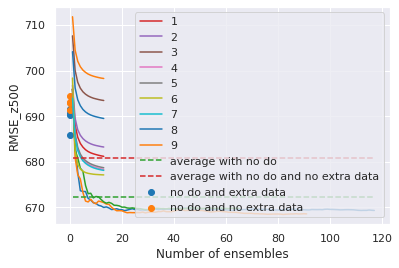

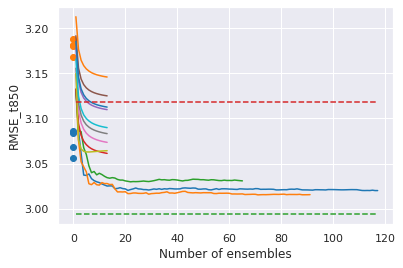

In [27]:
# effect of doing ensembles
plt.plot([i +1 for i in range(len(ens_rmse_list))], [ens_rmse_list[i].z for i in range(len(ens_rmse_list))])
plt.plot([i +1 for i in range(len(ens_rmse_list_less))], [ens_rmse_list_less[i].z for i in range(len(ens_rmse_list_less))])
plt.plot([i +1 for i in range(len(ens_rmse_list_less2))], [ens_rmse_list_less2[i].z for i in range(len(ens_rmse_list_less2))])
plt.plot([i +1 for i in range(len(ens_rmse_list_1))], [ens_rmse_list_1[i].z for i in range(len(ens_rmse_list_1))], label = '1')
plt.plot([i +1 for i in range(len(ens_rmse_list_2))], [ens_rmse_list_2[i].z for i in range(len(ens_rmse_list_2))], label = '2')
plt.plot([i +1 for i in range(len(ens_rmse_list_3))], [ens_rmse_list_3[i].z for i in range(len(ens_rmse_list_3))], label = '3')
plt.plot([i +1 for i in range(len(ens_rmse_list_4))], [ens_rmse_list_4[i].z for i in range(len(ens_rmse_list_4))], label = '4')
plt.plot([i +1 for i in range(len(ens_rmse_list_5))], [ens_rmse_list_5[i].z for i in range(len(ens_rmse_list_5))], label = '5')
plt.plot([i +1 for i in range(len(ens_rmse_list_6))], [ens_rmse_list_6[i].z for i in range(len(ens_rmse_list_6))], label = '6')
plt.plot([i +1 for i in range(len(ens_rmse_list_7))], [ens_rmse_list_7[i].z for i in range(len(ens_rmse_list_7))], label = '7')
plt.plot([i +1 for i in range(len(ens_rmse_list_8))], [ens_rmse_list_8[i].z for i in range(len(ens_rmse_list_8))], label = '8')
plt.plot([i +1 for i in range(len(ens_rmse_list_9))], [ens_rmse_list_9[i].z for i in range(len(ens_rmse_list_9))], label = '9')

plt.scatter([0, 0, 0, 0], [690.3, 686, 690.8, 691.7], label = 'no do and extra data')
plt.scatter([0, 0, 0, 0], [693.2, 691.4, 692.9, 694.4], label = 'no do and no extra data')
plt.plot([i +1 for i in range(len(ens_rmse_list))], [672.23781159 for i in range(len(ens_rmse_list))], '--', label = 'average with no do')
plt.plot([i +1 for i in range(len(ens_rmse_list))], [680.75255966 for i in range(len(ens_rmse_list))], '--', label = 'average with no do and no extra data')
plt.xlabel('Number of ensembles')
plt.ylabel('RMSE_z500')
plt.legend()
plt.show()

plt.plot([i +1 for i in range(len(ens_rmse_list))], [ens_rmse_list[i].t for i in range(len(ens_rmse_list))])
plt.plot([i +1 for i in range(len(ens_rmse_list_less))], [ens_rmse_list_less[i].t for i in range(len(ens_rmse_list_less))])
plt.plot([i +1 for i in range(len(ens_rmse_list_less2))], [ens_rmse_list_less2[i].t for i in range(len(ens_rmse_list_less2))])
plt.plot([i +1 for i in range(len(ens_rmse_list_1))], [ens_rmse_list_1[i].t for i in range(len(ens_rmse_list_1))])
plt.plot([i +1 for i in range(len(ens_rmse_list_2))], [ens_rmse_list_2[i].t for i in range(len(ens_rmse_list_2))])
plt.plot([i +1 for i in range(len(ens_rmse_list_3))], [ens_rmse_list_3[i].t for i in range(len(ens_rmse_list_3))])
plt.plot([i +1 for i in range(len(ens_rmse_list_4))], [ens_rmse_list_4[i].t for i in range(len(ens_rmse_list_4))])
plt.plot([i +1 for i in range(len(ens_rmse_list_5))], [ens_rmse_list_5[i].t for i in range(len(ens_rmse_list_5))])
plt.plot([i +1 for i in range(len(ens_rmse_list_6))], [ens_rmse_list_6[i].t for i in range(len(ens_rmse_list_6))])
plt.plot([i +1 for i in range(len(ens_rmse_list_7))], [ens_rmse_list_7[i].t for i in range(len(ens_rmse_list_7))])
plt.plot([i +1 for i in range(len(ens_rmse_list_8))], [ens_rmse_list_8[i].t for i in range(len(ens_rmse_list_8))])
plt.plot([i +1 for i in range(len(ens_rmse_list_9))], [ens_rmse_list_9[i].t for i in range(len(ens_rmse_list_9))])
#plt.plot(np.arange(len(ens_rmse_list)), [3.122 for i in range(len(ens_rmse_list))], '--', label = 'no dropout')
plt.scatter([0, 0, 0, 0], [3.068, 3.084, 3.086, 3.056])
plt.scatter([0, 0, 0, 0], [3.181, 3.18, 3.168, 3.188])
plt.plot([i +1 for i in range(len(ens_rmse_list))], [2.99354082 for i in range(len(ens_rmse_list))], '--')
plt.plot([i +1 for i in range(len(ens_rmse_list))], [3.11833834 for i in range(len(ens_rmse_list))], '--')

plt.xlabel('Number of ensembles')
plt.ylabel('RMSE_t850')
plt.show()

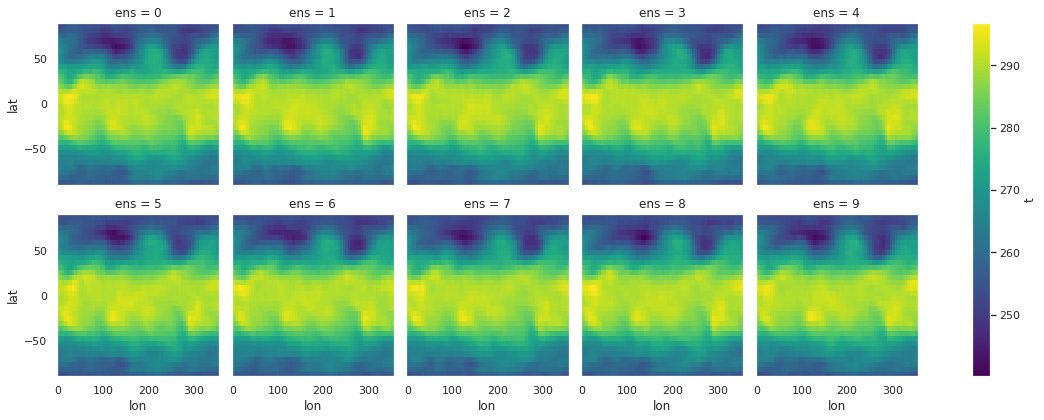

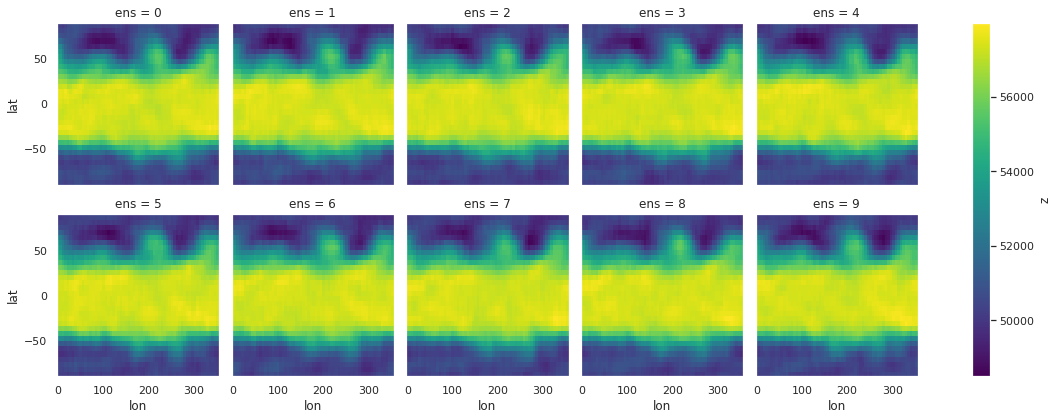

In [28]:
preds_1.t.isel(time = 0, ens = slice(0, 10)).plot(col='ens', col_wrap=5)
plt.show()
preds_1.z.isel(time = 0, ens = slice(0, 10)).plot(col='ens', col_wrap=5)
plt.show()

In [29]:
ens_t_total = ens.t/52
ens_z_total = ens.z/52

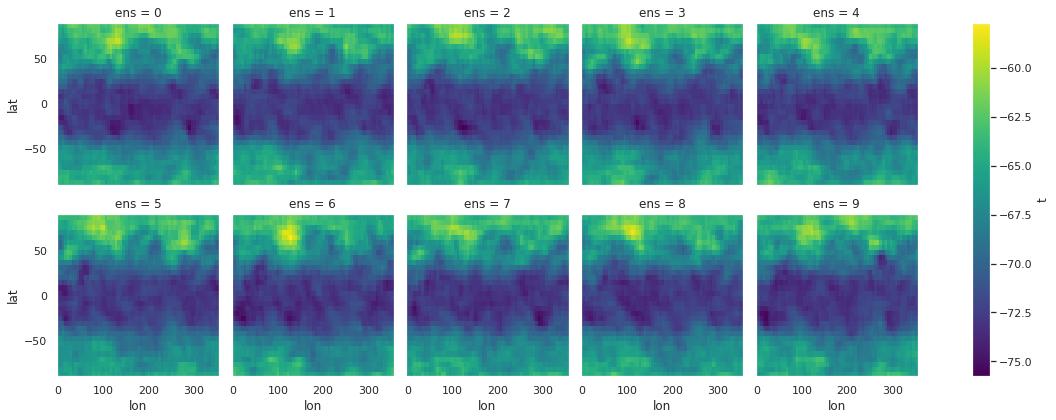

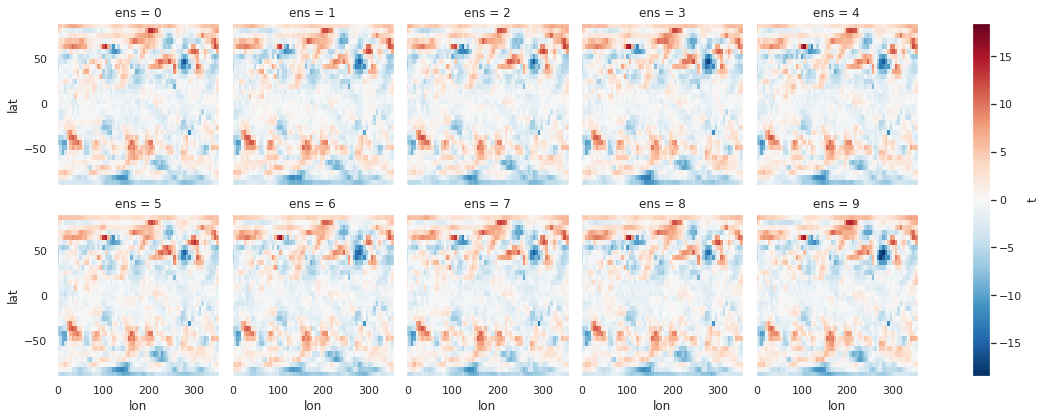

In [30]:
(preds_1.t.isel(time = 0) - ens_t_total.isel(time = 0)).isel(ens = slice(0,10)).plot(col='ens', col_wrap=5)
plt.show()
(preds_1.t.isel(time = 0) - real_ds.t.isel(time = 0)).isel(ens = slice(0, 10)).plot(col = 'ens', col_wrap = 5)
plt.show()

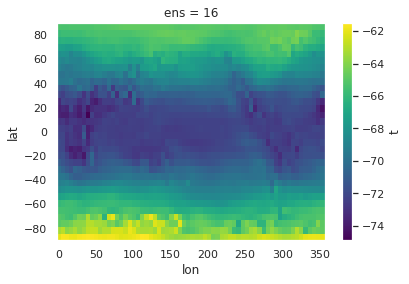

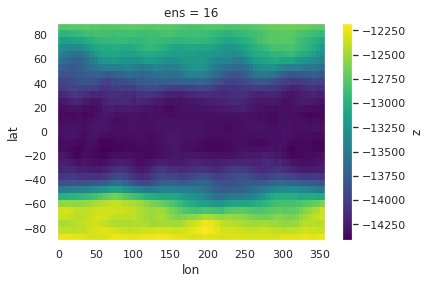

In [31]:
mean_ens_t = sum([real_ds.t.isel(time = i)-ens_t_total.isel(time = i) for i in range(len(real_ds.time))])/len(real_ds.time)
mean_ens_t.plot()
plt.show()
mean_ens_z = sum([real_ds.z.isel(time = i)-ens_z_total.isel(time = i) for i in range(len(real_ds.time))])/len(real_ds.time)
mean_ens_z.plot()
plt.show()

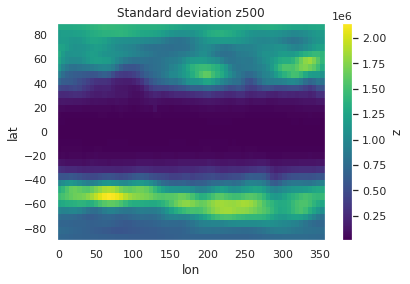

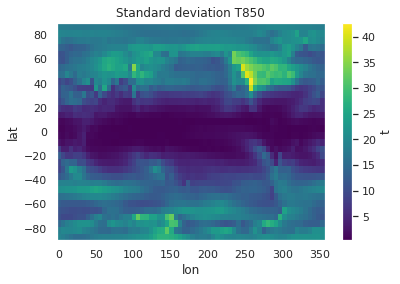

In [32]:
meansq_ens_z = sum([(real_ds.z.isel(time = i)-ens_z_total.isel(time = i))**2 for i in range(len(real_ds.time))])/len(real_ds.time)
(meansq_ens_z-mean_ens_z**2).plot()
plt.title('Standard deviation z500')
plt.show()
meansq_ens_t = sum([(real_ds.t.isel(time = i)-ens_t_total.isel(time = i))**2 for i in range(len(real_ds.time))])/len(real_ds.time)
(meansq_ens_t-mean_ens_t**2).plot()
plt.title('Standard deviation T850')
plt.show()

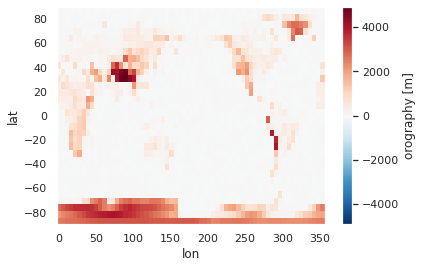

In [33]:
ds_whole.orography.plot()